## CMA-ES for CartPole Torch
### Christian Igel, 2023

If you have suggestions for improvement, [let me know](mailto:igel@diku.dk).

In [56]:
import gymnasium as gym  # Defines RL environments

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4,4)  # Set size of visualization
from IPython.display import clear_output  # For inline visualization

import torch
import torch.nn as nn
import torch.nn.functional as F

import cma

# Define task
env = gym.make('CartPole-v1')
state_space_dimension = env.observation_space.shape[0]
action_space_dimension = 1  # env.action_space.n - 1

Define the policy network:

In [57]:
# Model definition
class NeuralNetwork(nn.Module):
    def __init__(self, bias):
        super(NeuralNetwork, self).__init__()
        self.layout = nn.Sequential(
            nn.Linear(4, 5, bias=bias),
            nn.Tanh(),
            nn.Linear(5, 1, bias=bias)
        )
    
    def forward(self, x):
        output = self.layout(x)
        return output


In [58]:
policy_net = NeuralNetwork(bias = False)

Compute number of parameters:

In [59]:
d = sum(
	param.numel() for param in policy_net.parameters()
)
print("Number of parameters:", d)

Number of parameters: 25


Helper function for visualization:

In [60]:
def visualize_policy(policy_net):
    env_render = gym.make('CartPole-v1', render_mode='rgb_array')
    state = env_render.reset()  # Forget about previous episode
    state_tensor = torch.Tensor( state[0].reshape((1, state_space_dimension)) )
    steps = 0
    while True:
        out = policy_net(state_tensor)
        a = int(out > 0)
        state, reward, terminated, truncated, _ = env_render.step(a)  # Simulate pole
        steps+=1
        state_tensor = torch.Tensor( state.reshape((1, state_space_dimension)) )
        clear_output(wait=True)
        plt.imshow(env_render.render())
        plt.show()
        print("step:", steps)
        if(terminated or truncated): 
            break
    env_render.close()
    return state

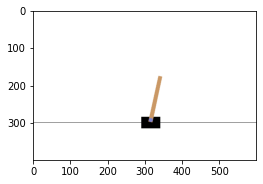

step: 55


array([0.12661101, 0.1816336 , 0.2111618 , 0.8486111 ], dtype=float32)

In [61]:
visualize_policy(policy_net)

Now we define the objective/reward function. 
When the task is solved the functions returns -1000.
One successful trial is sufficient.

In [62]:
def fitness_cart_pole(x, nn, env):
    '''
    Returns negative accumulated reward for single pole, fully environment.

    Parameters:
        x: Parameter vector encoding the weights.
        nn: Parameterized model.
        env: Environment ('CartPole-v?').
    '''
    torch.nn.utils.vector_to_parameters(torch.Tensor(x), nn.parameters())  # Set the policy parameters
    
    state = env.reset()  # Forget about previous episode
    state_tensor = torch.Tensor( state[0].reshape((1, state_space_dimension)) )
          
    R = 0  # Accumulated reward
    while True:
        out = nn(state_tensor)
        a = int(out > 0)
        state, reward, terminated, truncated, _ = env.step(a)  # Simulate pole
        state_tensor = torch.Tensor( state.reshape((1, state_space_dimension)) )
        R += reward  # Accumulate 
        if truncated:
            return -1000  # Episode ended, final goal reached, we consider minimization
        if terminated:
            return -R  # Episode ended, we consider minimization
    return -R  # Never reached  

Do the learning:

In [63]:
# Generate initial search point and initial hidden RNN states
initial_weights = np.random.normal(0, 0.01, d)  # Random parameters for initial policy, d denotes the number of weights
initial_sigma = .01 # Initial global step-size sigma

# Do the optimization
res = cma.fmin(fitness_cart_pole,  # Objective function
               initial_weights,  # Initial search point
               initial_sigma,  # Initial global step-size sigma
               args=([policy_net, env]),  # Arguments passed to the fitness function
               options={'ftarget': -999.9, 'tolflatfitness':1000, 'eval_final_mean':False})
env.close()

# Set the policy parameters to the final solution
torch.nn.utils.vector_to_parameters(torch.Tensor(res[0]), policy_net.parameters())  

print("best solution found after", res[2], "evaluations")

(6_w,13)-aCMA-ES (mu_w=4.0,w_1=38%) in dimension 25 (seed=1043361, Tue Feb 21 12:09:57 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     13 -1.000000000000000e+03 1.0e+00 9.52e-03  9e-03  1e-02 0:00.2
termination on ftarget=-999.9 (Tue Feb 21 12:09:57 2023)
final/bestever f-value = -1.000000e+03 -1.000000e+03 after 13/2 evaluations
incumbent solution: [-0.0078853  -0.0008297  -0.00206513 -0.00152869  0.00328055 -0.02176785
  0.01338449  0.01326658 ...]
std deviations: [0.00948805 0.00952308 0.00949718 0.00954936 0.00949721 0.00953629
 0.00951041 0.00948916 ...]
best solution found after 2 evaluations


Render solution:

In [64]:
#visualize_policy(policy_net)

In [65]:
def learn(env, bias):
    # dataframe to easily store and compute results
    results = []
    for i in range(10):
        policy_net = NeuralNetwork(bias=bias)
        d = sum(param.numel() for param in policy_net.parameters())

        initial_weights = np.random.normal(0, 0.01, d)  # Random parameters for initial policy, d denotes the number of weights
        initial_sigma = .01 # Initial global step-size sigma

        # Do the optimization
        res = cma.fmin(fitness_cart_pole,  # Objective function
                       initial_weights,  # Initial search point
                       initial_sigma,  # Initial global step-size sigma
                       args=([policy_net, env]),  # Arguments passed to the fitness function
                       options={'ftarget': -999.9, 'tolflatfitness':1000, 'eval_final_mean':False})
        env.close()

        # Set the policy parameters to the final solution
        torch.nn.utils.vector_to_parameters(torch.Tensor(res[0]), policy_net.parameters())  
        # store solution
        results.append([res[2], policy_net])
        #print("best solution found after", res[2], "evaluations")
    print(f"Done computing solutions for bias = {bias}")
    return pd.DataFrame(results)

In [66]:
model_bias = learn(env,bias=True)
model_no_bias = learn(env,bias=False)

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 31 (seed=1036350, Tue Feb 21 12:09:57 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.100000000000000e+01 1.0e+00 9.14e-03  9e-03  9e-03 0:00.0
    2     28 -2.900000000000000e+01 1.1e+00 8.62e-03  9e-03  9e-03 0:00.0
    3     42 -1.000000000000000e+01 1.1e+00 8.30e-03  8e-03  8e-03 0:00.1
   88   1232 -9.300000000000000e+01 2.7e+00 7.83e-03  5e-03  9e-03 0:03.1
  100   1400 -1.150000000000000e+02 2.9e+00 7.49e-03  5e-03  9e-03 0:04.0
  151   2114 -2.440000000000000e+02 3.9e+00 5.40e-03  3e-03  7e-03 0:09.1
  188   2632 -1.000000000000000e+03 4.4e+00 5.01e-03  2e-03  6e-03 0:13.4
termination on ftarget=-999.9 (Tue Feb 21 12:10:11 2023)
final/bestever f-value = -1.000000e+03 -1.000000e+03 after 2632/2620 evaluations
incumbent solution: [-0.0217374   0.03752249 -0.02488817  0.05598773  0.0032467  -0.01548695
 -0.05333332 -0.00898713 ...]
std deviations: [0.00491023 0.00483682 0.00491515 0.0051

In [67]:
avg_model_bias = model_bias[0].mean()
avg_model_no_bias = model_no_bias[0].mean()
print(f"average # of evaluation biased model: {avg_model_bias}")
print(f"average # of evaluation unbiased model: {avg_model_no_bias}")

average # of evaluation biased model: 1235.5
average # of evaluation unbiased model: 28.6


In [68]:
def policy(policy_net, seed):
    env_render = gym.make('CartPole-v1', render_mode=None)
    state = env_render.reset(seed=seed)
    state_tensor = torch.Tensor(state[0].reshape((1, state_space_dimension)))
    steps = 0
    while True:
        out = policy_net(state_tensor)
        a = int(out > 0)
        state, reward, terminated, truncated, _ = env_render.step(a)
        steps += 1
        state_tensor = torch.Tensor(state.reshape((1, state_space_dimension)))
        clear_output(wait=True)
        print("step:", steps)
        if(terminated or truncated): 
            break
    env_render.close()
    return steps

In [69]:
avg_number_step_bias_model = []
avg_number_step_unbiased_model = []
for i in model_bias[1]:
    avg_number_step_bias_model.append(run_policy(i,69))
for i in model_no_bias[1]:
    avg_number_step_unbiased_model.append(run_policy(i,69))



step: 266


In [70]:
print(f"average # of evaluation biased model: {np.mean(avg_number_step_bias_model)}")
print(f"average # of evaluation unbiased model: {np.mean(avg_number_step_unbiased_model)}")

average # of evaluation biased model: 187.9
average # of evaluation unbiased model: 276.9


Learn more about CMA-ES optimization:

In [71]:
# Visualize the optimization 
#cma.plot();  

In [72]:
# Learn even more on CMA-ES
#cma.CMAOptions() 